# Introduction


Imagine we have a fixed amount of initial investment and we want to set up a short-term investment plan.

We can either decide to invest **all at once** into the stock market at the beginning of each year, or apply the **dollar-cost averaging** or **value averaging** on a **monthly** or **quarterly** basis. 

Which method could maximize our investment return?

Let's do some backtests using the SP500 index performance data. 

In [1]:
# Import libraries
import datetime

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

plt.style.use('bmh')

In [2]:
# Get historical data
startdate = datetime.datetime(1988, 1, 1)
enddate = datetime.datetime(2021, 1, 1)

# SP 500 total return index
SP = pdr.get_data_yahoo('^SP500TR', start=startdate, end=enddate)
SP['date'] = SP.index

# Compare all-in with [dollar cost averaging](https://en.wikipedia.org/wiki/Dollar_cost_averaging)

Let's first assume that the timeframe for the short-term investment plan is one year and the investment should start at the beginning of each year. Hence. each year between 1980 and 2020 is an individual sample. 

In this section, I will compare the annual return rates for these investment plans:

- Plan 1: All-in approach at the beginning of a year
- Plan 2: Divide the initial investment into 12 folds and invest at the beginning of each month
- Plan 3: Divide the initial investment into 4 folds and invest at the beginning of each quarter 

In [3]:
# Plan 1: All-in
# Group by year
SP['date'] = SP.index
SP['year'] = SP['date'].apply(lambda d: f'{d.year}')
df = SP[['year', 'Adj Close']].groupby('year').first()
df['return'] = df['Adj Close'].pct_change()
df['return_next_y'] = df['return'].shift(-1)

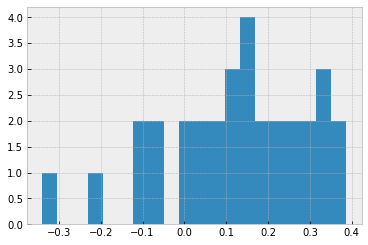

In [4]:
# Get a feeling of the return rate per year
df['return_next_y'].hist(bins=20);

In [5]:
# Plan 2: Monthly dollar-cost averaging
# Group by month
SP['month'] = SP['date'].apply(lambda d: f'{d.month:02d}')
df_m = SP[['year', 'month', 'Adj Close']].groupby(['year','month']).first()
df_m['return'] = df_m['Adj Close'].pct_change()
df_m['return_next'] = df_m['return'].shift(-1)

In [6]:
# Plan 3: Quarterly dollar-cost averaging
# Group by quarter
SP['quarter'] = SP['month'].apply(lambda m: int(m)//4 + 1)
df_q = SP[['year', 'quarter', 'Adj Close']].groupby(['year','quarter']).first()
df_q['return'] = df_q['Adj Close'].pct_change()
df_q['return_next'] = df_q['return'].shift(-1)

Here is how the dataframe for the quarterly dollar-cost averaging looks like:

In [7]:
df_q.head()

Adj Close    return  return_next
year quarter                                   
1988 1        256.019989       NaN     0.009335
     2        258.410004  0.009335     0.074881
     3        277.760010  0.074881     0.015085
     4        281.950012  0.015085     0.013123
1989 1        285.649994  0.013123     0.085979

In [8]:
# Function for calcuting dollar-cost averaging returns
def calc_return_over_periods_list(
    investment_per_period_list: list, 
    return_per_period_list: list, 
    n_period: int, 
    print_values: bool = False) -> float:
    
    """
    This function calculates the overall rate of return of the dollar-cost averaging strategy.
    :param investment_per_period_list: Investment value at the beginning of each period.
    :param return_per_period_list: Historical return rate per period.
    :param n_period: number of periods for calculating the overall return rate.
    :param print_values: Whether to display the value each period and overall return rate or not
    :return: A dataframe that contains all the relevant info
    """
    
    value=0 
    
    for i in range(n_period):       
        value += investment_per_period_list[i]
        value = value * (1 + return_per_period_list[i])
        if print_values:
            print(i, value)
            
    return_rate = value/sum(investment_per_period_list) - 1
    
    if print_values:
        print(f'The overall return rate is {round(return_rate*100,2)}%')
    
    return return_rate

Here is how the function works for calculating the overall return for a dollar-cost averaging strategy:


In [9]:
# Assuming investing 300 dollars at the beginning of each quarter
calc_return_over_periods_list(
    investment_per_period_list = [300]*4, 
    return_per_period_list = df_q.loc['2019','return_next'].tolist(), 
    n_period=4, 
    print_values=True)

0 344.452725052093
1 668.0476321454007
2 1027.8678104390076
3 1391.5380752126462
The overall return rate is 15.96%


0.15961506267720504

In [10]:
# Join dollar-cost averaging results together into one dataframe
df = df.drop(columns='return')

for year in SP.year.unique()[:-1]:
    # for monthly dollar-cost averaging annual return
    df.loc[f'{int(year)}', 'return_next_m'] = (
    calc_return_over_periods_list(
        [1]*12, 
        df_m.loc[(f'{year}'),'return_next'].tolist(), 
        12)
    )
    
    # for quarterly dollar-cost averaging annual return
    df.loc[f'{int(year)}', 'return_next_q'] = (
    calc_return_over_periods_list(
        [1]*4, 
        df_q.loc[(f'{year}'),'return_next'].tolist(), 
        4)
    )
    
df.round(3)

,Adj Close,return_next_y,return_next_m,return_next_q
year,,,,
1988,256.02,0.116,0.059,0.066
1989,285.65,0.352,0.152,0.172
1990,386.16,-0.059,-0.008,-0.031
1991,363.44,0.320,0.137,0.165
1992,479.84,0.075,0.064,0.057
1993,516.00,0.099,0.047,0.053
1994,567.10,0.015,0.015,0.029
1995,575.52,0.387,0.188,0.198
1996,798.22,0.214,0.121,0.120


With the dataframe above, we can easily compare the performance of these three short-term investment plans: 

In [11]:
# Return_next_y is the annual return for all-in method
# Return_next_m is the annual return of the monthly dollar cost averaging method
# Return_next_q is the annual return of the quarterly dollar cost averaging method 
df[['return_next_y','return_next_m','return_next_q']].describe().round(3)

,return_next_y,return_next_m,return_next_q
count,32.000,32.000,32.000
mean,0.121,0.068,0.068
std,0.169,0.099,0.096
min,-0.341,-0.229,-0.189
25%,0.023,0.009,0.012
50%,0.142,0.083,0.084
75%,0.243,0.142,0.140
max,0.387,0.249,0.207


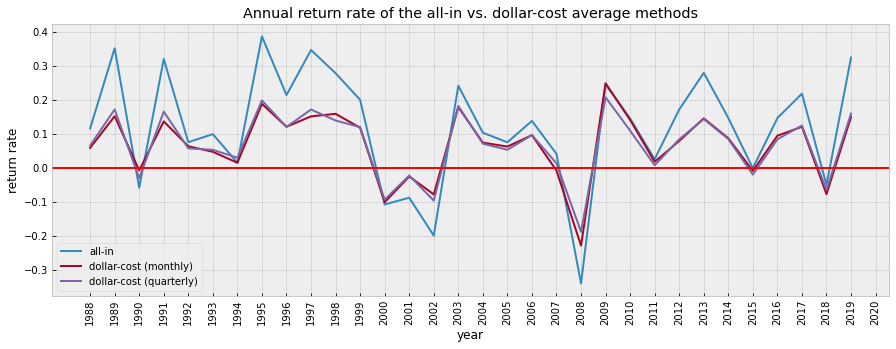

In [12]:
plt.figure(figsize=(15,5))
plt.plot(df['return_next_y'], label='all-in')
plt.plot(df['return_next_m'], label='dollar-cost (monthly)')
plt.plot(df['return_next_q'], label='dollar-cost (quarterly)')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('year')
plt.ylabel('return rate')
plt.xticks(rotation=90)
plt.title('Annual return rate of the all-in vs. dollar-cost average methods')
plt.legend()
plt.show()

## Observation


Given that you already have a fixed amount of initial investment and you want to invest it into an ETF based on SP500, all-in method performed better than both monthly and quarterly dollar-cost averaging methods in most of the past years. 

This is because SP500 has a tendency of increasing in most of the past years; and the all-in method maximized the gain. 

However, dollar-cost averaging method helps to reduce loss in a bear market.

It seems that only in the following years SP500 has a negative year-over-year return. 

In [13]:
list(df.loc[df['return_next_y']<=0,:].index)

['1990', '2000', '2001', '2002', '2008', '2015', '2018']

The bear markets does not seem to last long using the SP 500 index (usually less than 2 years).

So, it might be a good time to start investing if the last year was a bear market.

If it is already a bull market, you can decide whether you still want to risk it with the all-in method.

If it is already a bear market, it might be a good time to start investing.

# Compare with [value averaging](https://en.wikipedia.org/wiki/Value_averaging)

In the last notebook, we already discussed the method of value averaging for long term investment, and we assumed that it might work for short term investment. 

Let's check the annual return of the value averaging method here:

In [14]:
# This is an adjusted version of the function that we have introduced in the last notebook for value averaging
def calc_value_averaging_return(df: pd.DataFrame, value_per_period: float = 1.0, 
                                increase_investment_per_period: float = 0.0) -> float:
    """
    This function calculates the overall return rate of the value averaging strategy.
    :param df: Original dataframe that contains the price at the beginning of each period
    :param value_per_period: Investment value per period
    :param increase_investment_per_period: Increase the investment by x each period
    :return: overall return rate (might be negative if the total withdraw amount is too much)
    """
    df_va = pd.DataFrame.copy(df)
    value = value_per_period
    df_va.loc[0,'target_value'] = value
    df_va.loc[0,'shares_should_have_in_total'] = value_per_period/df_va.loc[0,'Adj Close']
    df_va.loc[0,'shares_to_buy_or_sell'] = value_per_period/df_va.loc[0,'Adj Close']
    df_va.loc[0,'should_invest_or_withdraw'] = value
    df_va.loc[0,'total_invest_or_withdraw'] = value

    for i in range(1,len(df_va.index)):
        value += value_per_period*((1 + increase_investment_per_period)**i)
        df_va.loc[i,'target_value'] = value
        df_va.loc[i,'shares_should_have_in_total'] = df_va.loc[i,'target_value']/df_va.loc[i,'Adj Close']
        df_va.loc[i,'shares_to_buy_or_sell'] = df_va.loc[i,'shares_should_have_in_total'] - df_va.loc[i-1,'shares_should_have_in_total']
        df_va.loc[i,'should_invest_or_withdraw'] = df_va.loc[i,'shares_to_buy_or_sell']*df_va.loc[i,'Adj Close']
        df_va.loc[i,'total_invest_or_withdraw'] = df_va.loc[i-1,'total_invest_or_withdraw'] + df_va.loc[i,'should_invest_or_withdraw']

    return df_va.loc[len(df_va.index)-1,'target_value']/df_va.loc[len(df_va.index)-1,'total_invest_or_withdraw']-1

In [15]:
# Assuming fixed investment value each year
value_per_year = 1200
value_per_quarter = value_per_year/4
value_per_month = value_per_year/12

df_va_m = df_m['Adj Close'].reset_index()
df_va_q = df_q['Adj Close'].reset_index()

### Join results together into one dataframe
for year in SP.year.unique()[:-1]:
    df_va_m_sample = df_va_m.loc[df_va_m['year']==year,:].reset_index()
    df_va_q_sample = df_va_q.loc[df_va_q['year']==year,:].reset_index()
    annual_return_va_m = calc_value_averaging_return(df_va_m_sample, value_per_month)
    annual_return_va_q = calc_value_averaging_return(df_va_q_sample, value_per_quarter)
    df.loc[f'{int(year)}', 'return_va_m'] = annual_return_va_m
    df.loc[f'{int(year)}', 'return_va_q'] = annual_return_va_q

In [16]:
# Join value averaging with dollar cost averaging results
df.round(3)

,Adj Close,return_next_y,return_next_m,return_next_q,return_va_m,return_va_q
year,,,,,,
1988,256.02,0.116,0.059,0.066,0.049,0.054
1989,285.65,0.352,0.152,0.172,0.128,0.152
1990,386.16,-0.059,-0.008,-0.031,-0.011,-0.037
1991,363.44,0.320,0.137,0.165,0.037,0.065
1992,479.84,0.075,0.064,0.057,0.052,0.045
1993,516.00,0.099,0.047,0.053,0.038,0.044
1994,567.10,0.015,0.015,0.029,-0.008,0.005
1995,575.52,0.387,0.188,0.198,0.171,0.188
1996,798.22,0.214,0.121,0.120,0.165,0.170


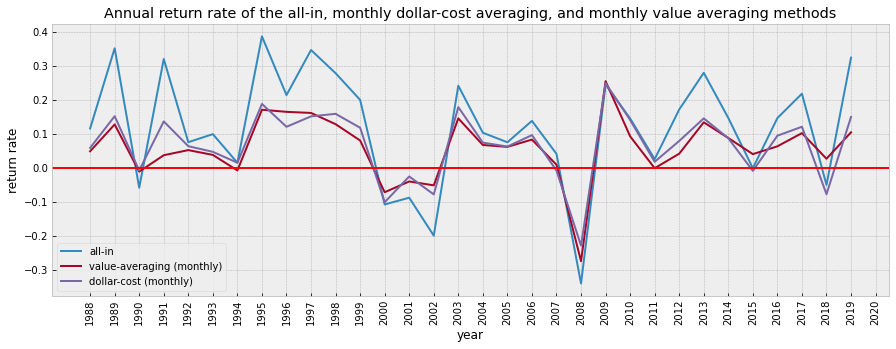

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['return_next_y'], label='all-in')
plt.plot(df['return_va_m'], label='value-averaging (monthly)')
# plt.plot(df['return_va_q'], label='value-averaging (quarterly)')
plt.plot(df['return_next_m'], label='dollar-cost (monthly)')
# plt.plot(df['return_next_q'], label='dollar-cost (quarterly)')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('year')
plt.ylabel('return rate')
plt.xticks(rotation=90)
plt.title('Annual return rate of the all-in, monthly dollar-cost averaging, and monthly value averaging methods')
plt.legend()
plt.show()

In [18]:
def compare_strategy(df, str1, str2, str1_name, str2_name):
    print(f'number of times {str1_name} is better than {str2_name}: {df.loc[df[str1] > df[str2],:].shape[0]}')
    print(f'number of times {str1_name} is equal to {str2_name}: {df.loc[df[str1] == df[str2],:].shape[0]}')
    print(f'number of times {str1_name} is worse than {str2_name}: {df.loc[df[str1] < df[str2],:].shape[0]}')

In [19]:
compare_strategy(df, 'return_va_m', 'return_next_m', 'monthly value-averaging', 'monthly dollar-cost-averaging')

number of times monthly value-averaging is better than monthly dollar-cost-averaging: 9
number of times monthly value-averaging is equal to monthly dollar-cost-averaging: 0
number of times monthly value-averaging is worse than monthly dollar-cost-averaging: 23


In [20]:
compare_strategy(df, 'return_next_y', 'return_next_m', 'all-in', 'monthly dollar-cost-averaging')

number of times all-in is better than monthly dollar-cost-averaging: 26
number of times all-in is equal to monthly dollar-cost-averaging: 0
number of times all-in is worse than monthly dollar-cost-averaging: 6


## Observation

It seems that the annual return of the dollar-cost averaging and value averaging did not differ much, even though the monthly value averaging method was worse than the monthly dollar-cost-averaging in most years.

Again, all-in method brings the most gain but also involves the most risk.

# What if we use a multi-year timeframe?

The test below involves a multiple year short-term investment plan. The rate of return below indicates the overall rate of return of investing for x years starting from a certain year.

Let's see if using dollar cost averaging or value averaging helps to improve the peformance.

In [21]:
SP

,High,Low,Open,Close,Volume,Adj Close,date,year,month,quarter
Date,,,,,,,,,,
1988-01-04,256.019989,256.019989,256.019989,256.019989,0,256.019989,1988-01-04,1988,01,1
1988-01-05,258.769989,258.769989,258.769989,258.769989,0,258.769989,1988-01-05,1988,01,1
1988-01-06,259.029999,259.029999,259.029999,259.029999,0,259.029999,1988-01-06,1988,01,1
1988-01-07,261.209991,261.209991,261.209991,261.209991,0,261.209991,1988-01-07,1988,01,1
1988-01-08,243.550003,243.550003,243.550003,243.550003,0,243.550003,1988-01-08,1988,01,1
...,...,...,...,...,...,...,...,...,...,...
2020-09-21,6757.350098,6641.330078,6757.350098,6748.080078,0,6748.080078,2020-09-21,2020,09,3
2020-09-22,6828.669922,6727.319824,6778.330078,6819.080078,0,6819.080078,2020-09-22,2020,09,3
2020-09-23,6835.209961,6649.240234,6828.919922,6657.819824,0,6657.819824,2020-09-23,2020,09,3


In [22]:
def compare_returns(SP, n_years):
    """
    This function aims to compare 5 n-year short-term investment plans based on a certain ETF/stock's performance data.
    :param SP: Original dataframe that contains a certain ETF/stock's performance data
    :param n_years: Number of years set for the short-term investment plan
    :return: A dataframe that contains the overall return for the 5 plans
    """
    test_months = 12*n_years
    test_quarters = 4*n_years

    df = SP[['year', 'Adj Close']].groupby('year').first()

    # Compute all in return
    df['return'] = df['Adj Close'].pct_change(periods=n_years)
    df['return_next'] = df['return'].shift(-n_years)
    df = df.drop(columns='return')

    for year in SP.year.unique()[:-n_years]:
        # Compute monthly dollar cost averaging return
        df.loc[f'{int(year)}', 'return_next_m'] = (
        _calc_return_over_periods_list_simplified(
            [1]*test_months, 
            df_m.loc[(f'{year}'):(f'{int(year) + n_years - 1}'),'return_next'].tolist(), 
            test_months)
        )

        # Compute quarterly dollar cost averaging return
        df.loc[f'{int(year)}', 'return_next_q'] = (
        _calc_return_over_periods_list_simplified(
            [1]*test_quarters, 
            df_q.loc[(f'{year}'):(f'{int(year) + n_years - 1}'),'return_next'].tolist(), 
            test_quarters)
        )

    # Compute value averaging returns    
    df_va_m = df_m['Adj Close'].reset_index()
    df_va_q = df_q['Adj Close'].reset_index()

    ### Join results together into one dataframe
    for year in SP.year.unique()[:-n_years]:
        df_va_m_sample = df_va_m.loc[(df_va_m['year']>=year) & 
                                     (df_va_m['year']<=str(int(year) + n_years - 1)),:].reset_index()
        df_va_q_sample = df_va_q.loc[(df_va_q['year']>=year) & 
                                     (df_va_q['year']<=str(int(year) + n_years - 1)),:].reset_index()
        annual_return_va_m = _calc_value_averaging_return_simplified(df_va_m_sample)
        annual_return_va_q = _calc_value_averaging_return_simplified(df_va_q_sample)
        df.loc[f'{int(year)}', 'return_va_m'] = annual_return_va_m
        df.loc[f'{int(year)}', 'return_va_q'] = annual_return_va_q
    
    return df


def _calc_return_over_periods_list_simplified(
    investment_per_period_list: list, 
    return_per_period_list: list, 
    n_period: int, 
    print_values=False) -> float:
    
    value = 0
    for i in range(n_period):
        value += investment_per_period_list[i]
        value = value * (1 + return_per_period_list[i])
    return_rate = value/sum(investment_per_period_list) - 1
    
    return return_rate


def _calc_value_averaging_return_simplified(df_va, value_per_period=1):
    
    df_va.loc[0,'total_value'] = value_per_period
    df_va.loc[0,'shares_should_have_in_total'] = value_per_period/df_va.loc[0,'Adj Close']
    df_va.loc[0,'shares_to_buy_or_sell'] = value_per_period/df_va.loc[0,'Adj Close']
    df_va.loc[0,'should_invest'] = value_per_period
    df_va.loc[0,'total_invest'] = value_per_period

    for i in range(1,len(df_va.index)):
        df_va.loc[i,'total_value'] = value_per_period*(i+1)
        df_va.loc[i,'shares_should_have_in_total'] = df_va.loc[i,'total_value']/df_va.loc[i,'Adj Close']
        df_va.loc[i,'shares_to_buy_or_sell'] = df_va.loc[i,'shares_should_have_in_total'] - df_va.loc[i-1,'shares_should_have_in_total']
        df_va.loc[i,'should_invest'] = df_va.loc[i,'shares_to_buy_or_sell']*df_va.loc[i,'Adj Close']
        df_va.loc[i,'total_invest'] = df_va.loc[i-1,'total_invest'] + df_va.loc[i,'should_invest']
    
    return df_va.loc[len(df_va.index)-1,'total_value']/df_va.loc[len(df_va.index)-1,'total_invest']-1

In [23]:
def plot_changes(df):
    plt.figure(figsize=(15,5))
    plt.plot(df['return_next'], label='all-in')
    plt.plot(df['return_va_m'], label='value-averaging (monthly)')
    # plt.plot(df['return_va_q'], label='value-averaging (quarterly)')
    plt.plot(df['return_next_m'], label='dollar-cost (monthly)')
    # plt.plot(df['return_next_q'], label='dollar-cost (quarterly)')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('year')
    plt.ylabel('return rate')
    plt.xticks(rotation=90)
    plt.title('Annual return rate of the all-in, monthly dollar-cost averaging, and monthly value averaging methods')
    plt.legend()
    plt.show()

In [24]:
# Assuming we are setting up a 2 year plan and then compare the return
test_years = 2
df_2 = compare_returns(SP, test_years)

In [25]:
df_2.round(3)

,Adj Close,return_next,return_next_m,return_next_q,return_va_m,return_va_q
year,,,,,,
1988,256.02,0.508,0.291,0.306,0.296,0.322
1989,285.65,0.272,0.038,0.036,0.039,0.030
1990,386.16,0.243,0.223,0.222,0.127,0.130
1991,363.44,0.420,0.143,0.155,0.138,0.152
1992,479.84,0.182,0.108,0.107,0.102,0.102
1993,516.00,0.115,0.039,0.049,0.017,0.026
1994,567.10,0.408,0.298,0.313,0.308,0.340
1995,575.52,0.684,0.281,0.287,0.367,0.390
1996,798.22,0.635,0.330,0.340,0.393,0.437


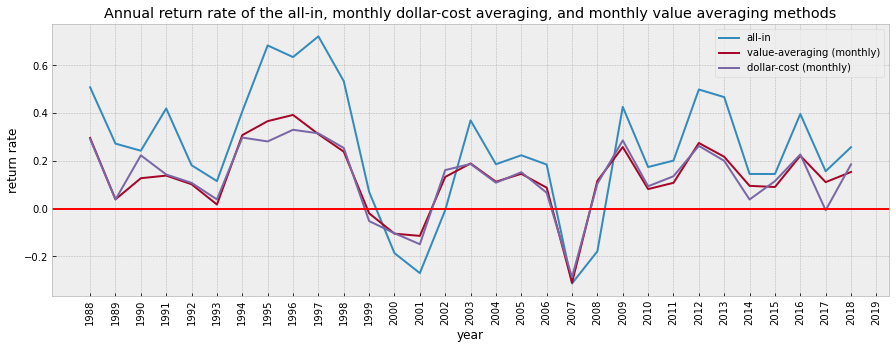

In [26]:
plot_changes(df_2)

In [27]:
compare_strategy(df_2, 'return_va_m', 'return_next_m', 'monthly value-averaging', 'monthly dollar-cost-averaging')

number of times monthly value-averaging is better than monthly dollar-cost-averaging: 15
number of times monthly value-averaging is equal to monthly dollar-cost-averaging: 0
number of times monthly value-averaging is worse than monthly dollar-cost-averaging: 16


In [28]:
compare_strategy(df_2, 'return_next', 'return_next_m', 'all-in', 'monthly dollar-cost-averaging')

number of times all-in is better than monthly dollar-cost-averaging: 26
number of times all-in is equal to monthly dollar-cost-averaging: 0
number of times all-in is worse than monthly dollar-cost-averaging: 5


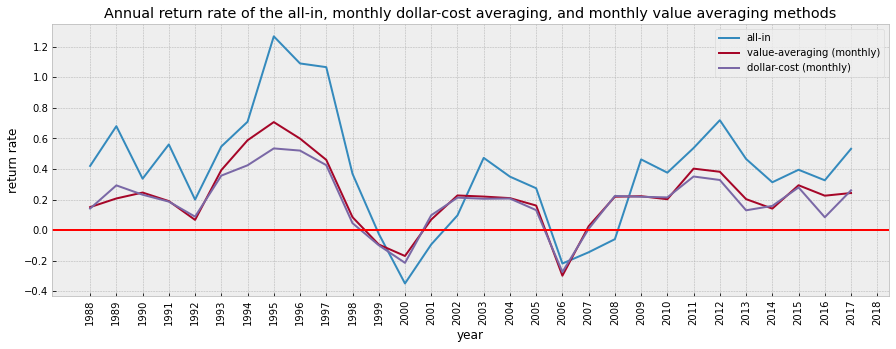

In [29]:
# Assuming we are setting up a 3 year plan and then compare the return
test_years = 3
df_3 = compare_returns(SP, test_years)

plot_changes(df_3)

In [30]:
compare_strategy(df_3, 'return_va_m', 'return_next_m', 'monthly value-averaging', 'monthly dollar-cost-averaging')

number of times monthly value-averaging is better than monthly dollar-cost-averaging: 22
number of times monthly value-averaging is equal to monthly dollar-cost-averaging: 0
number of times monthly value-averaging is worse than monthly dollar-cost-averaging: 8


In [31]:
compare_strategy(df_3, 'return_next', 'return_next_m', 'all-in', 'monthly dollar-cost-averaging')

number of times all-in is better than monthly dollar-cost-averaging: 25
number of times all-in is equal to monthly dollar-cost-averaging: 0
number of times all-in is worse than monthly dollar-cost-averaging: 5


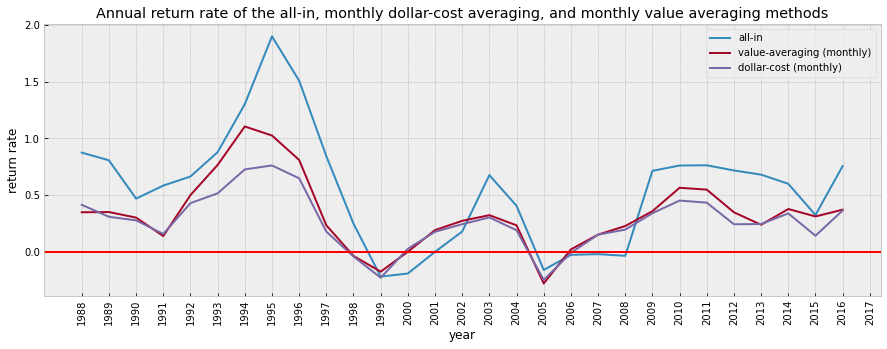

In [32]:
# Assuming we are setting up a 4 year plan and then compare the return
test_years = 4
df_4 = compare_returns(SP, test_years)

plot_changes(df_4)

In [33]:
compare_strategy(df_4, 'return_va_m', 'return_next_m', 'monthly value-averaging', 'monthly dollar-cost-averaging')

number of times monthly value-averaging is better than monthly dollar-cost-averaging: 24
number of times monthly value-averaging is equal to monthly dollar-cost-averaging: 0
number of times monthly value-averaging is worse than monthly dollar-cost-averaging: 5


In [34]:
compare_strategy(df_4, 'return_next', 'return_next_m', 'all-in', 'monthly dollar-cost-averaging')

number of times all-in is better than monthly dollar-cost-averaging: 23
number of times all-in is equal to monthly dollar-cost-averaging: 0
number of times all-in is worse than monthly dollar-cost-averaging: 6


# Conclusion

When we have a fixed amount of money, in most cases, using the all-in method performs the best, but it also involves higher risk.

The value averaging strategy did not differ much from the dollar cost averaging. When it is a one or two year short investment plan, the dollar cost averaging is more likely to perform better; if it is a three or four year investment plan, the value averaging strategy is more likely to perform better.

Given that the value averaging strategy is a bit tedious to implement, I think it is better to use either all-in or dollar-cost averaging for short term investment.

Please note that, in this notebook, I did not use the adjusted version of the value averaging method with the minimum and maximum thresholds of investment per period (as introduced in BP3 Plan 3). It might bring you some extra return if it is a longer term investment plan.